# Simple Oracles
Oracles are blackboxes. You don't need to know what is inside. You just need to know it takes some inputs and maps them to outputs.

This notebook will guide you through, using Qiskit, the ideas to implement the following oracles. The oracles which are implemented can have many applications in quantum algorithms, for example, Grover's algorithm.

1. OrOracle
2. AndOracle
3. ControlledOnInt
4. ControlledOnBit

Firstly, we import the libraries and initialise some variables.

We will be experimenting with 5 qubits.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from qiskit import IBMQ, Aer, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.quantum_info import state_fidelity
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.generalized_gates.mcmt import MCMT
from qiskit.circuit.library.standard_gates.x import XGate, HGate
from qiskit.circuit.library import ZGate
from qiskit.visualization import plot_histogram

In [2]:
#n is the number of qubits
n = 5

## OrOracle

The purpose of the OrOracle is to tell whether at least one bit in the quantum register is a '1'. Algorithmically, it is sufficient to check if all the bits are '0'. If so, the ancilla qubit will remain '0'. 

To implement the oracle, we flip all qubits in the qubit register and the ancilla qubit. If the resultant register is all in '1', it means none of them are '1' in the first place, hence ancilla qubit will be flipped back to '0' (by using a XGate controlled on all qubits in the register). Otherwise, the ancilla qubit remains in '1'.

At the end of the Oracle, we flip all the qubits in the register back to their original states.

Sometimes, it is useful to have a Oracle that does a function on the ancilla qubit, rather than just a XGate. The function OrOracleGate helps with that. The insight is that we can first apply the input gate to the ancilla qubit. If all qubits are '0' initially, apply the inverse gate (since all operators are unitary). Otherwise, leave it as it is.

In [3]:
or_q = QuantumRegister(n)
or_c = ClassicalRegister(1)
or_circuit = QuantumCircuit(or_q, or_c)

In [4]:
#INPUT THE QUBITS TO TOGGLE
or_circuit.x(1)

In [5]:
#nn = size of given_circuit
def OrOracle(given_circuit, nn, target_qubit):
    given_circuit.barrier()
    given_circuit.x(target_qubit)
    controlled_xgate = XGate().control(nn)
    for i in range(nn):
        given_circuit.x(i)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_xgate, curlist)
    for i in range(nn):
        given_circuit.x(i)
    given_circuit.barrier()


def OrOracleGate(given_circuit, nn, target_qubit, gate):
    given_circuit.barrier()
    given_circuit.append(gate, [target_qubit])
    controlled_gate = (gate.inverse()).control(nn)
    for i in range(nn):
        given_circuit.x(i)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_gate, curlist)
    for i in range(nn):
        given_circuit.x(i)
    given_circuit.barrier()

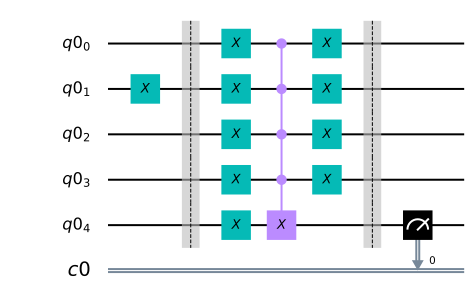

In [6]:
OrOracle(or_circuit, n - 1, n - 1)
or_circuit.measure(n - 1, 0)
or_circuit.draw('mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(or_circuit, simulator, shots=1000).result().get_counts(or_circuit)
print("\nThe results for OrOracle are:",counts)



The results for OrOracle are: {'1': 1000}


Now we try experimenting with the OrOracleGate, using HGate() as an example.

In [8]:
orf_q = QuantumRegister(n)
orf_c = ClassicalRegister(1)
orf_circuit = QuantumCircuit(orf_q, orf_c)

for i in range(4):
    orf_circuit.x(i)

OrOracleGate(orf_circuit, n - 1, n - 1, HGate())

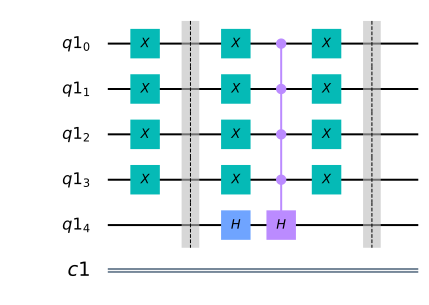

In [9]:
orf_circuit.draw('mpl')

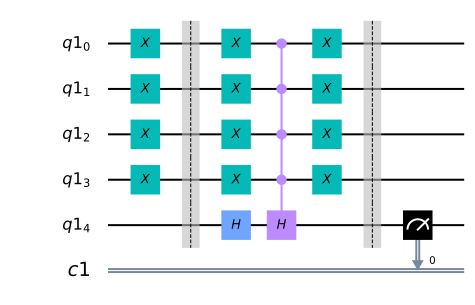

In [10]:
orf_circuit.measure(n - 1, 0)
orf_circuit.draw('mpl')

In [11]:
simulator = Aer.get_backend('qasm_simulator')
counts = execute(orf_circuit, simulator, shots=1000).result().get_counts(orf_circuit)
print("\nThe results for OrOracleGate are:",counts)


The results for OrOracleGate are: {'0': 504, '1': 496}


## AndOracle

AndOracle is simpler than OrOracle, in the sense that the controlled Gate could be directly applied. Since all qubits in the register must be '1' for there to be an operator to be applied to the ancilla qubit, we can just do a controlled form of the operator.

Similarly, AndOracleGate is implemented to allow more variations of gates to be applied.

In [12]:
and_q = QuantumRegister(n)
and_c = ClassicalRegister(1)
and_circuit = QuantumCircuit(and_q, and_c)

In [13]:
#INPUT THE QUBITS TO TOGGLE
for i in range(n - 1):
    and_circuit.x(i)

In [14]:
#nn = size of given_circuit
def AndOracle(given_circuit, nn, target_qubit):
    given_circuit.barrier()
    controlled_xgate = XGate().control(nn)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_xgate, curlist)
    given_circuit.barrier()
    
def AndOracleGate(given_circuit, nn, target_qubit, gate):
    given_circuit.barrier()
    controlled_gate = gate.control(nn)
    curlist = list(range(0, nn))
    curlist.append(target_qubit)
    given_circuit.append(controlled_gate, curlist)
    given_circuit.barrier()

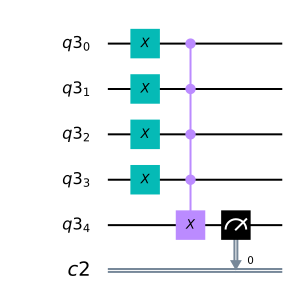

In [15]:
AndOracle(and_circuit, n - 1, n - 1)
and_circuit.measure(n - 1, 0)
and_circuit.draw('mpl')

In [14]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(and_circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(and_circuit)
print("\nThe results for AndOracle are:",counts)


The results for AndOracle are: {'0': 1000}


Now we try experimenting with the AndOracleGate, using HGate() as an example.

In [15]:
andf_q = QuantumRegister(n)
andf_c = ClassicalRegister(1)
andf_circuit = QuantumCircuit(andf_q, andf_c)

andf_circuit.x(0)
andf_circuit.x(1)
andf_circuit.x(2)
andf_circuit.x(3)

AndOracleGate(andf_circuit, n - 1, n - 1, HGate())

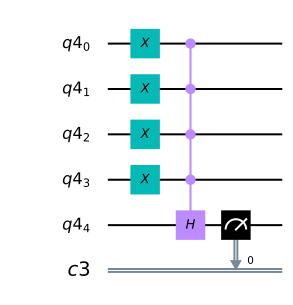

In [16]:
andf_circuit.measure(n - 1, 0)
andf_circuit.draw('mpl')

In [17]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(andf_circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(andf_circuit)
print("\nThe results for AndOracleGate are:",counts)


The results for AndOracleGate are: {'1': 508, '0': 492}


## ControlledOnIntOracle

Sometimes, ControlledOnIntOracle can prove to be useful. It can be used in searching algorithms. It can also be used if the coder wants to utilise brute force or implement some edge cases.

Similar to the OrOracle, ControlledOnIntOracle converts the qubit register (assuming qubit register is in the state of the integer) to all '1's. A controlled XGate will flip the ancilla qubit if the initial qubit register shows the state of the integer. Finally, all the qubits in the register are flipped back to their original states.

A ControlledOnIntOracleGate function is also implemented to experiment ControlledOnIntOracle with user defined gates instead of a standard XGate.

In [5]:
coi_q = QuantumRegister(n + 1)
coi_c = ClassicalRegister(1)
coi_circuit = QuantumCircuit(coi_q, coi_c)

coif_q = QuantumRegister(n + 1)
coif_c = ClassicalRegister(1)
coif_circuit = QuantumCircuit(coif_q, coif_c)

In [3]:
#nn = size of given_circuit excluding the target_qubit
def ControlledOnIntOracle(given_circuit, nn, target_qubit, x, reverse=False):
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    given_circuit.barrier()
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    AndOracle(given_circuit, nn, target_qubit)
    
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    given_circuit.barrier()
    
def ControlledOnIntOracleGate(given_circuit, nn, target_qubit, x, gate, reverse=False):
    
    if (x != 0 and nn < int(math.floor(math.log2(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    
    given_circuit.barrier()
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    AndOracleGate(given_circuit, nn, target_qubit, gate)
    
    xx = x
    counter = 0
    for i in range(nn):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    given_circuit.barrier()

In [7]:
coi_circuit.x(0)
coi_circuit.x(1)
coi_circuit.x(3)
coi_circuit.x(4)
coi_circuit.barrier()

6
[0, 1, 2, 3, 4, 5]


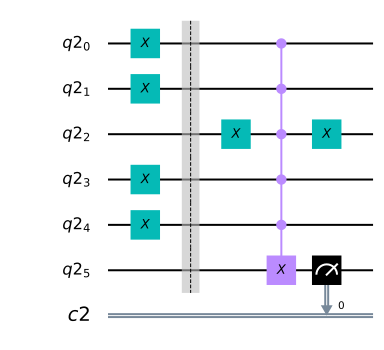

In [8]:
print(coi_circuit.num_qubits)
ControlledOnIntOracle(coi_circuit, 5, 5, 27)
coi_circuit.barrier()
coi_circuit.measure(5, 0)
coi_circuit.draw('mpl')

In [10]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(coi_circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(coi_circuit)
print("\nThe results for ControlledOnIntOracle are:",counts)


The results for ControlledOnOracle are: {'1': 1000}


Now let's experiment with the ControlledOnIntOracleGate function.

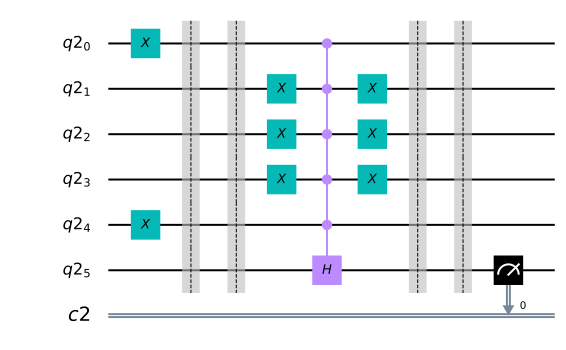

In [7]:
coif_circuit.x(0)
coif_circuit.x(4)
#coding for 9
coif_circuit.barrier()

ControlledOnIntOracleGate(coif_circuit, n, n, 17, HGate())
coif_circuit.barrier()
coif_circuit.measure(n, 0)
coif_circuit.draw('mpl')

In [8]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(coif_circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(coif_circuit)
print("\nThe results for ControlledOnIntOracleGate are:",counts)


The results for ControlledOnIntOracleGate are: {'1': 520, '0': 480}


### ControlledOnIntOracleGate used in Grover's Algorithm

In Grover's Search Algorithm, ControlledOnIntOracleGate could be used as the Oracle to highlight the marked element. 

The oracle shows f(x) = 1 if x is the marked element and f(x) = 0 for unmarked element.

Here, for a single marked element, if we know the index, the time complexity for building the oracle is maximally O(log(N)).

In [4]:
newn = 6
grover_qc = QuantumCircuit(newn + 1, newn, name = "Grover Circuit")
#+1 is for ancilla qubit

In [5]:
def GroverOracle(given_circuit, nn, indices_to_mark, name = 'Oracle'):

    for i in indices_to_mark:
        ControlledOnIntOracle(given_circuit, nn, nn, i)
        #given_circuit.append(ZGate().control(1), [nn, nn - 1])
        #ControlledOnIntOracle(given_circuit, nn, nn, i)
    # create a quantum circuit on n qubits
    #qc = QuantumCircuit(n, name=name)

    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    #oracle_matrix = np.identity(2**n)
    #for index_to_mark in indices_to_mark:
    #    oracle_matrix[index_to_mark, index_to_mark] = -1
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    #qc.unitary(Operator(oracle_matrix), range(n))
    
    #return qc

def diffuser(given_circuit, nn, name = "Diffuser"):
    
    given_circuit.h(range(nn))
    given_circuit.x(range(nn))
    controlled_gate = ZGate().control(nn - 1)
    given_circuit.append(controlled_gate, list(range(0, nn)))
    given_circuit.x(range(nn))
    #GroverOracle(given_circuit, nn, [0])
    #given_circuit.append(phase_oracle(n, [0]), range(n))
    given_circuit.h(range(nn))

def GroverAlgorithm(given_circuit, nn, indices_of_marked_elements):
    
    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**nn/len(indices_of_marked_elements))))
    print(f'{nn} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    given_circuit.h(range(nn))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        GroverOracle(given_circuit, nn, indices_of_marked_elements)
        diffuser(given_circuit, nn)
        #qc.append(phase_oracle(nn, indices_of_marked_elements), range(n))
        #qc.append(diffuser(nn), range(nn))
        
    # step 3: measure all qubits
    given_circuit.measure(range(nn), range(nn))

#mycircuit = Grover(6, [1, 42])
#ycircuit.draw(output='text')

In [6]:
GroverAlgorithm(grover_qc, newn, [22, 42])

6 qubits, basis states [22, 42] marked, 4 rounds


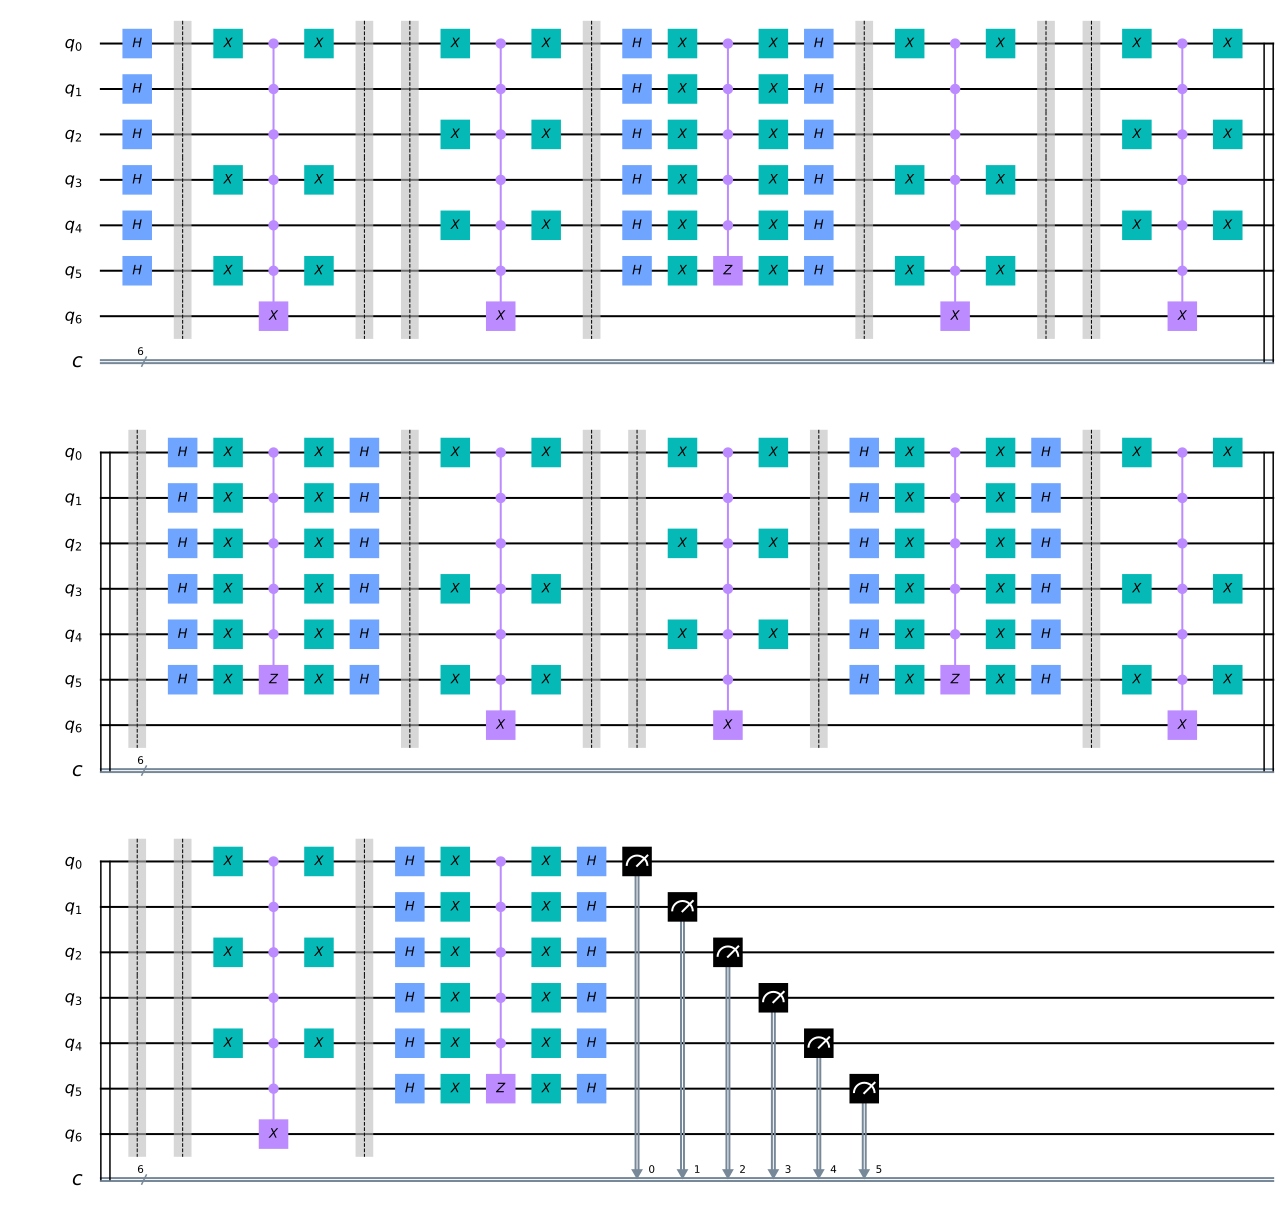

In [7]:
grover_qc.draw('mpl')

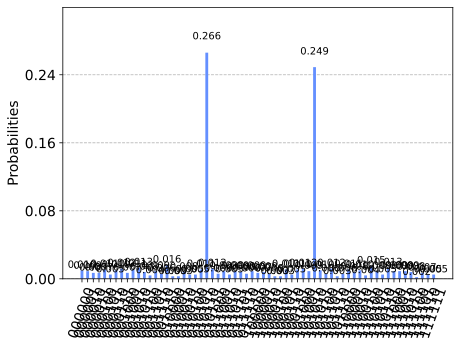

In [8]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(grover_qc, backend=simulator, shots=1000).result().get_counts(grover_qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

## ControlledOnBitOracle

In [ ]:
coi_q = QuantumRegister(n + 1)
coi_c = ClassicalRegister(1)
coi_circuit = QuantumCircuit(coi_q, coi_c)

In [ ]:
#nn = size of given_circuit excluding the target_qubit
def ControlledOnIntOracle(given_circuit, nn, target_qubit, x, reverse=False):
    if (nn < int(math.floor(math.log10(x) + 1))):
        print("Not enough qubits to do ControlledOnIntOracle\n")
        return
    xx = x
    counter = 0
    while (xx != 0):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1
    AndOracle(given_circuit, nn, target_qubit)
    
    xx = x
    counter = 0
    while (xx != 0):
        if (xx%2 == 0):
            given_circuit.x(counter)
        xx = (xx - (xx%2))/2
        counter = counter + 1

In [ ]:
coi_circuit.x(0)
coi_circuit.x(1)
coi_circuit.x(3)
coi_circuit.x(4)
coi_circuit.barrier()

In [ ]:
print(coi_circuit.num_qubits)
ControlledOnIntOracle(coi_circuit, 5, 5, 27)
coi_circuit.barrier()
coi_circuit.measure(5, 0)
coi_circuit.draw('mpl')

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(coi_circuit, simulator, shots=1000)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(coi_circuit)
print("\nThe results for ControlledOnOracle are:",counts)